In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df_ind = pd.read_csv('india.csv')

In [3]:
scaler = MinMaxScaler(feature_range=(0, 1))

df_ma = df_ind['new_cases'].values
period = 15

for i in range(period, len(df_ind['new_cases'].values)):
    ma = 0
    for j in range(i - period + 1, i + 1):
        ma += df_ind['new_cases'].values[j]
    df_ma[i] = ma / period

scaled_data = scaler.fit_transform(df_ma.reshape(-1, 1)) #reshape for (n, ) to (n, 1)


look_back = 125
prediction_days = 500

x_train, y_train = [], []

for x in range(look_back, len(scaled_data) - prediction_days):
  x_train.append(scaled_data[x - look_back: x, 0])
  y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [4]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))  #our predictions
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [5]:
model.fit(x_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
13/13 [==============================] - 9s 153ms/step - loss: 0.0562
Epoch 2/10
13/13 [==============================] - 2s 133ms/step - loss: 0.0163
Epoch 3/10
13/13 [==============================] - 4s 279ms/step - loss: 0.0064
Epoch 4/10
13/13 [==============================] - 4s 283ms/step - loss: 0.0073
Epoch 5/10
13/13 [==============================] - 4s 281ms/step - loss: 0.0067
Epoch 6/10
13/13 [==============================] - 4s 285ms/step - loss: 0.0046
Epoch 7/10
13/13 [==============================] - 4s 286ms/step - loss: 0.0046
Epoch 8/10
13/13 [==============================] - 4s 277ms/step - loss: 0.0044
Epoch 9/10
13/13 [==============================] - 4s 287ms/step - loss: 0.0036
Epoch 10/10
13/13 [==============================] - 4s 288ms/step - loss: 0.0034


In [6]:
last = x_train[len(scaled_data) - prediction_days - look_back - 1]
x_test = np.array([last])
ys = []
for i in range(0, prediction_days):
    ysi = model.predict(x_test)[0]
    ys.append(np.array([max(0, ysi[0])]))
    x_test = np.array([np.concatenate((last[1:], [ys[-1]]))])
    last = x_test[0]

In [7]:
predicted_cases = scaler.inverse_transform(ys)
pred = np.concatenate((df_ma[:len(scaled_data)-prediction_days], predicted_cases.reshape(-1,)))

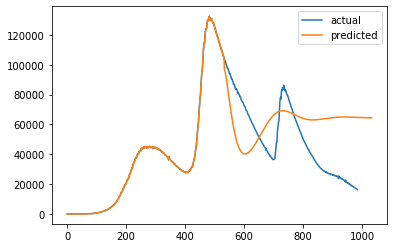

In [14]:
plt.figure()
plt.plot(df_ma, label="actual")
plt.plot(pred, label="predicted")
plt.legend()
plt.show()

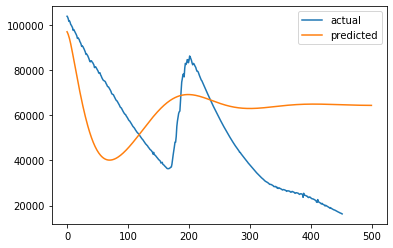

In [15]:
plt.figure()
plt.plot(df_ma[-prediction_days:], label="actual")
plt.plot(predicted_cases, label="predicted")
plt.legend()